In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
results_path = '../metrics/results/'

In [3]:
csv_paths = ['../metrics/results/cartolastd.csv', 
             '../metrics/results/cifar10cnn.csv',
             '../metrics/results/esc50.csv',
             '../metrics/results/fashion.csv',
             '../metrics/results/gaussians.csv',
             '../metrics/results/nnset.csv',
             '../metrics/results/qtables.csv',
             '../metrics/results/quickdraw.csv',
             '../metrics/results/sorts.csv',
             '../metrics/results/walk.csv']

In [4]:
def get_method(name):
    s = name
    s = s.split('/')[1]
    s = s.split('-', 1)[1]

    if s.startswith('tsne'):
        return s[:7]
    elif s.startswith('dtsne'):
        return 'dtsne'
    elif s.startswith('ldtsne'):
        return 'ldtsne'
    elif s.startswith('pcadtsne'):
        return 'pcadtsne'
    elif s.startswith('pca'):
        return s[:6]
    elif s.startswith('umap'):
        return s[:7]
    else:
        return s.split('_')[0]

In [5]:
df_metrics = pd.DataFrame()
for p in csv_paths:
    df = pd.read_csv(p)
    df = df.drop(['spat_kl', 'stab_kl'], axis=1)  # Bad metric
    # Extract dataset and method into own column
    df.columns = np.concatenate([['name'], df.columns.values[1:]])
    df['dataset'] = df.name.str.extract(r'.*/(.*).*')[0].str.split(r'[_-]').str[0]
    df['method'] = df['name'].apply(get_method)
    df = df.set_index('name')
    
    # Remove CAE and CVAE 
    df = df[df['method'] != 'C2AE']
    df = df[df['method'] != 'C2VAE']
    
    # Average nh and np metrics 
    nh_cols = [c for c in df.columns if 'spat_nh_' in c]
    df['spat_nh_mean'] = np.mean(df[nh_cols], axis=1)

    np_cols = [c for c in df.columns if 'spat_np_' in c]
    df['spat_np_mean'] = np.mean(df[np_cols], axis=1)
    
    np_cols = [c for c in df.columns if 'spat_trust_' in c]
    df['spat_trust_mean'] = np.mean(df[np_cols], axis=1)
    
    np_cols = [c for c in df.columns if 'spat_cont_' in c]
    df['spat_cont_mean'] = np.mean(df[np_cols], axis=1)
    
    df_metrics = pd.concat([df_metrics, df])

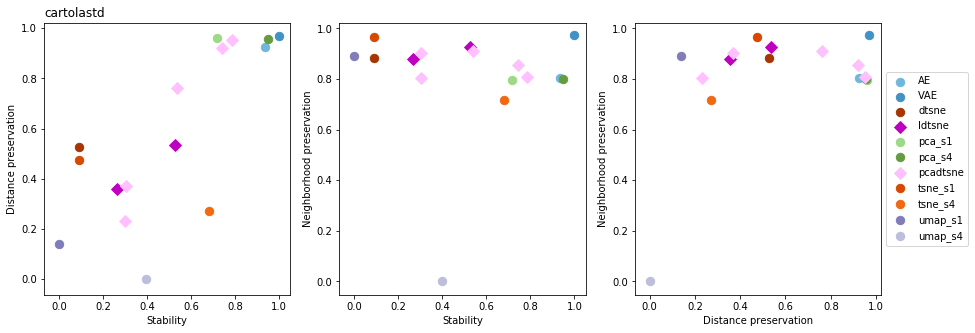

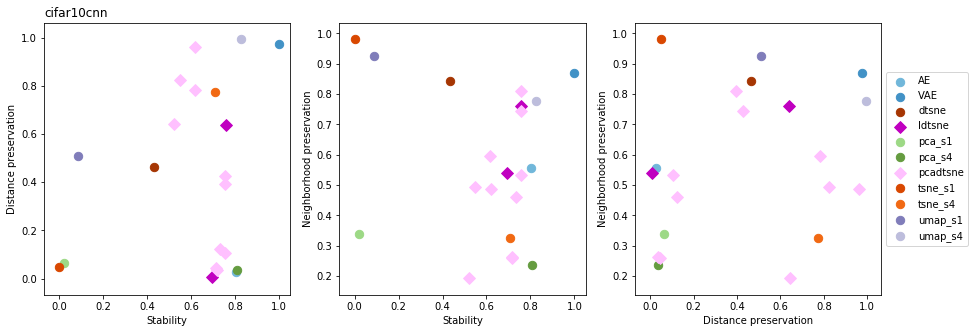

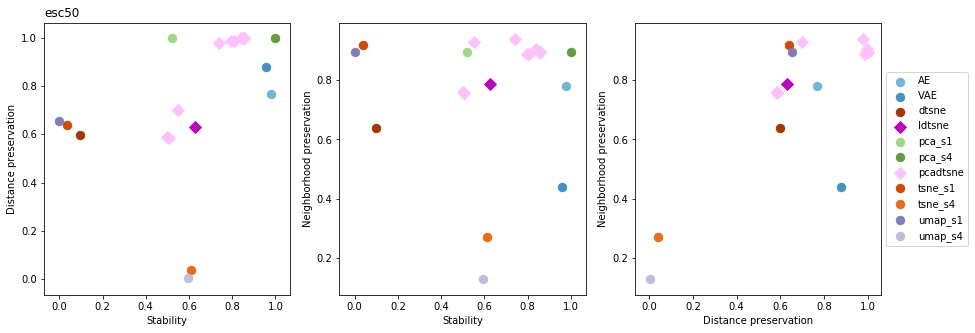

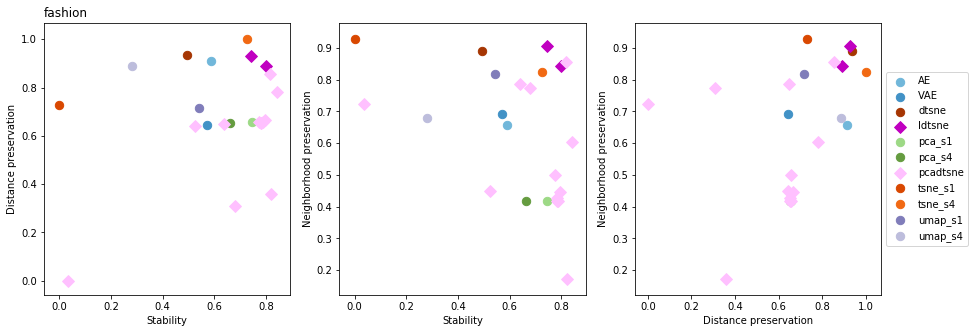

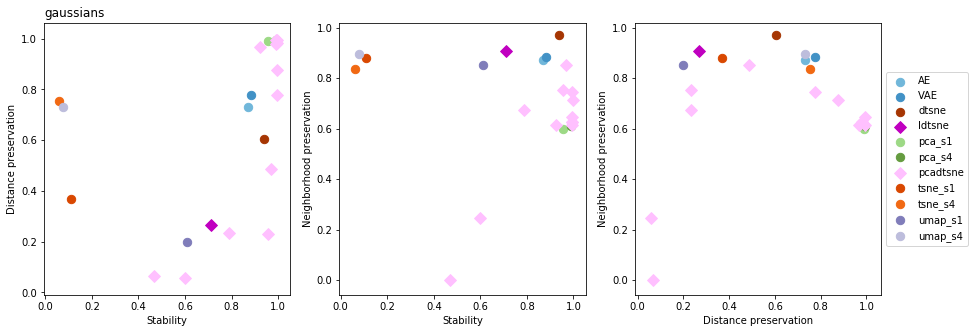

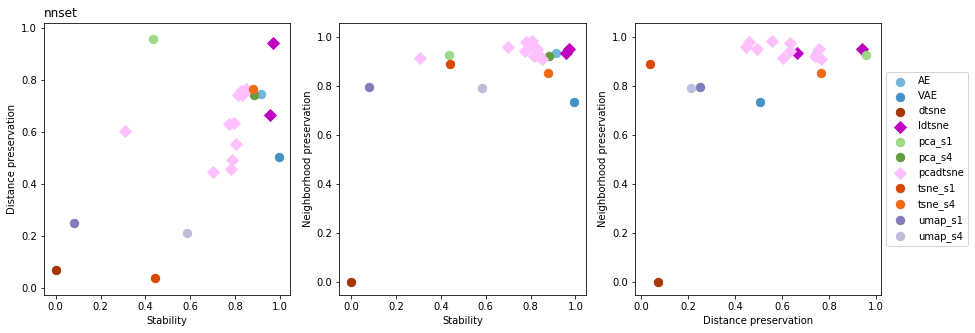

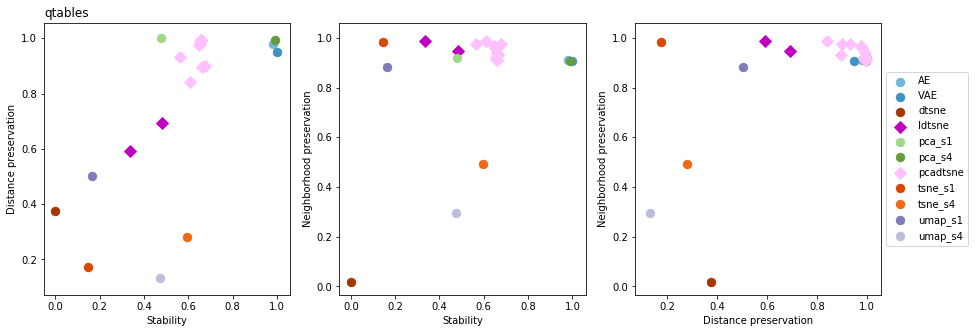

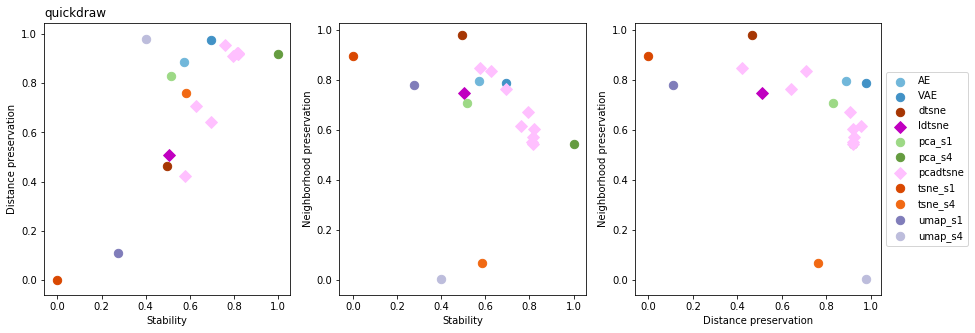

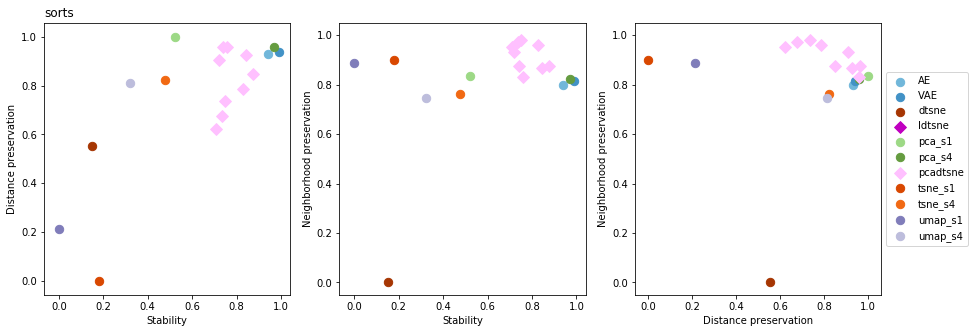

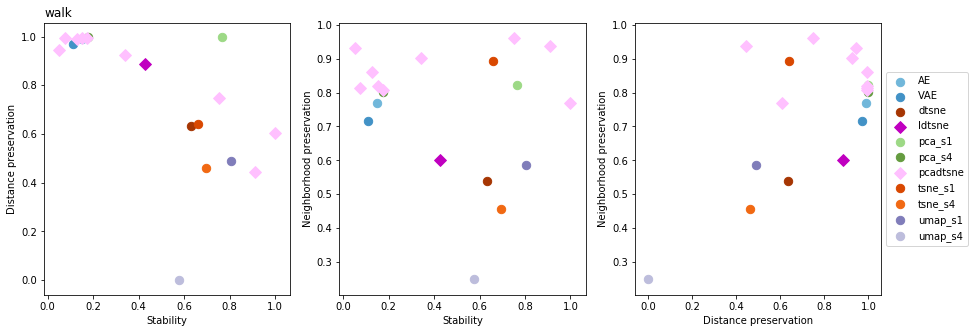

In [6]:
colors = {
    'AE' : '#71B7DA',
    'VAE' : '#4292C6',
    'dtsne' : '#A63603',
    'tsne_s1' : '#D94801',
    'tsne_s4' : '#F16913',
    'umap_s1' : '#807DBA',
    'umap_s4' : '#BDBDDC',
    'pca_s1' : '#9DD986',
    'pca_s4' : '#659C40',
    'ldtsne' : '#C000C0',
    'pcadtsne' : '#FFC0FF'    
}

for dataset in df_metrics['dataset'].factorize()[1]:
    methods = df_metrics[df_metrics['dataset'] == dataset]['method']
    
    df = df_metrics[df_metrics['dataset'] == dataset]
    df = df[['stab_pearson', 'stab_spearman' , 'stab_kendall', 'stab_stress_s']]
    stab_df = (df - df.min())/(df.max() - df.min())
    stab_df['stab_stress_s'] = 1 - stab_df['stab_stress_s']
#     display(stab_df)

    df = df_metrics[df_metrics['dataset'] == dataset]
    df = df[['spat_pearson', 'spat_spearman' , 'spat_kendall', 'spat_stress_s']]
    spat_df = (df - df.min())/(df.max() - df.min())
    spat_df['spat_stress_s'] = 1 - spat_df['spat_stress_s']
#     display(spat_df)

    df = df_metrics[df_metrics['dataset'] == dataset]
    df = df[['spat_nh_mean', 'spat_np_mean', 'spat_trust_mean', 'spat_cont_mean']]
    neigh_df = (df - df.min())/(df.max() - df.min())
#     display(neigh_df)

    
    fig, axs = plt.subplots(1, 3, figsize=(15,5))
    axs[0].set_title(dataset, loc='left')
    for i, name in enumerate(np.unique(df_metrics['method'])):
        marker = 'D' if name in ['pcadtsne', 'ldtsne'] else 'o'
        
        where = np.where(methods == name)[0]        
        axs[0].scatter(stab_df.mean(axis=1)[where], spat_df.mean(axis=1)[where], s=70, marker=marker, c=colors[name])
        axs[0].set_xlabel('Stability', fontsize=10)
        axs[0].set_ylabel('Distance preservation', fontsize=10)
        
        axs[1].scatter(stab_df.mean(axis=1)[where], neigh_df.mean(axis=1)[where], s=70, marker=marker, c=colors[name])
        axs[1].set_xlabel('Stability', fontsize=10)
        axs[1].set_ylabel('Neighborhood preservation', fontsize=10)
        
        axs[2].scatter(spat_df.mean(axis=1)[where], neigh_df.mean(axis=1)[where], s=70, marker=marker, c=colors[name], label=name)
        axs[2].set_xlabel('Distance preservation', fontsize=10)
        axs[2].set_ylabel('Neighborhood preservation', fontsize=10)
        
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [7]:
# methods = ['AE', 'VAE', 'h_spacer', 'tsne_s1', 'tsne_s4', 'dtsne', 'h_spacer', 'umap_s1', 'umap_s4', 'h_spacer', 'pca_s1', 'pca_s4', 'h_spacer', 'ldtsne']
# methods = df_metrics.index
metrics = ['spat_pearson', 'spat_spearman' , 'spat_kendall', 'spat_stress_s', 'v_spacer_1', 'spat_nh_mean', 'spat_np_mean', 'spat_trust_mean', 'spat_cont_mean', 'v_spacer_2', 'stab_pearson', 'stab_spearman' , 'stab_kendall', 'stab_stress_s']
invert_colormap = ['stab_stress_n', 'stab_stress_s', 'spat_stress_n', 'spat_stress_s']

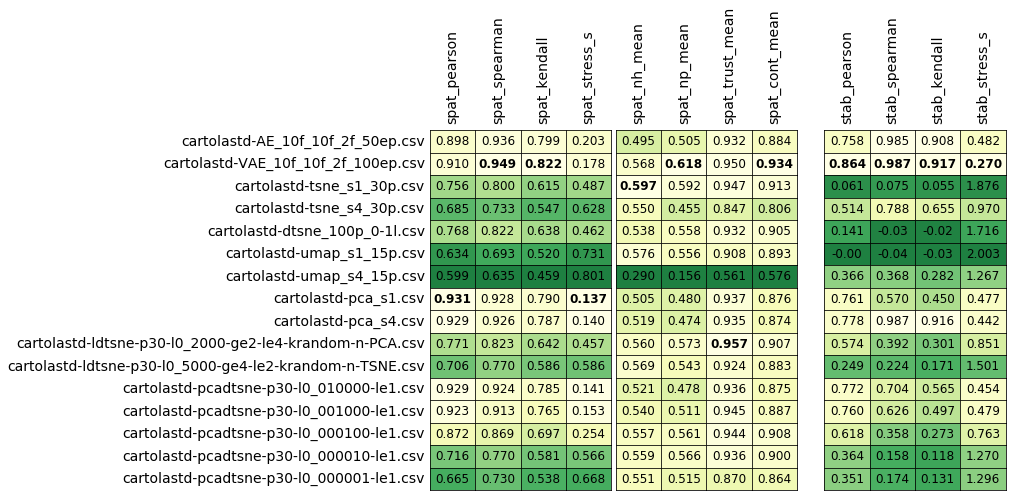

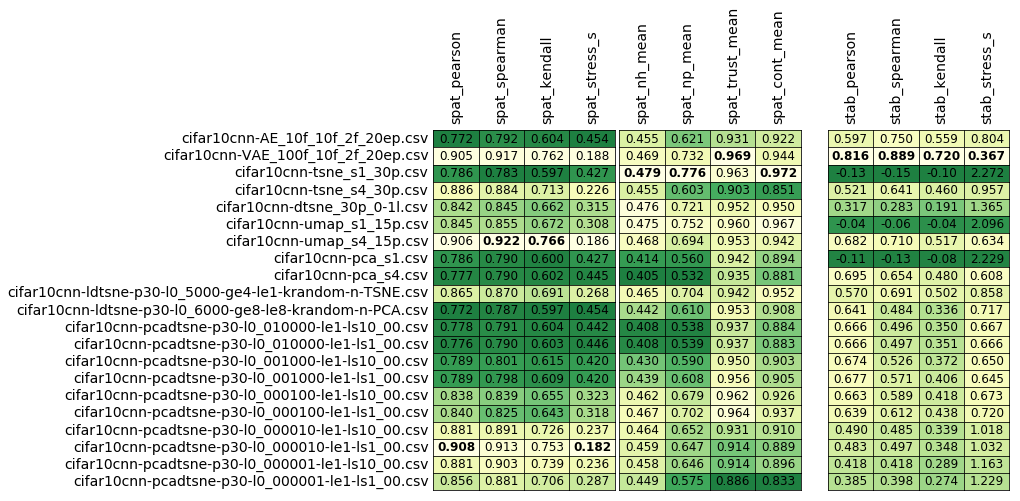

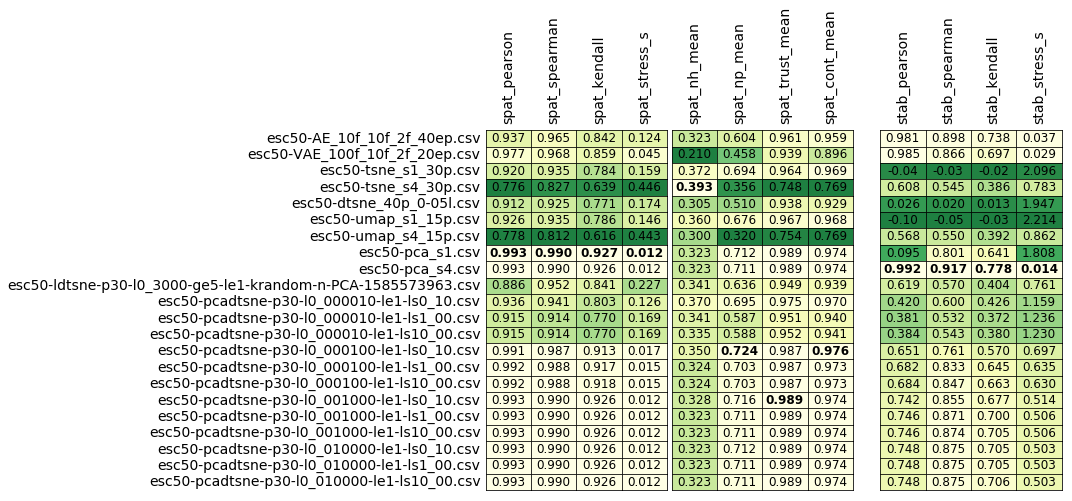

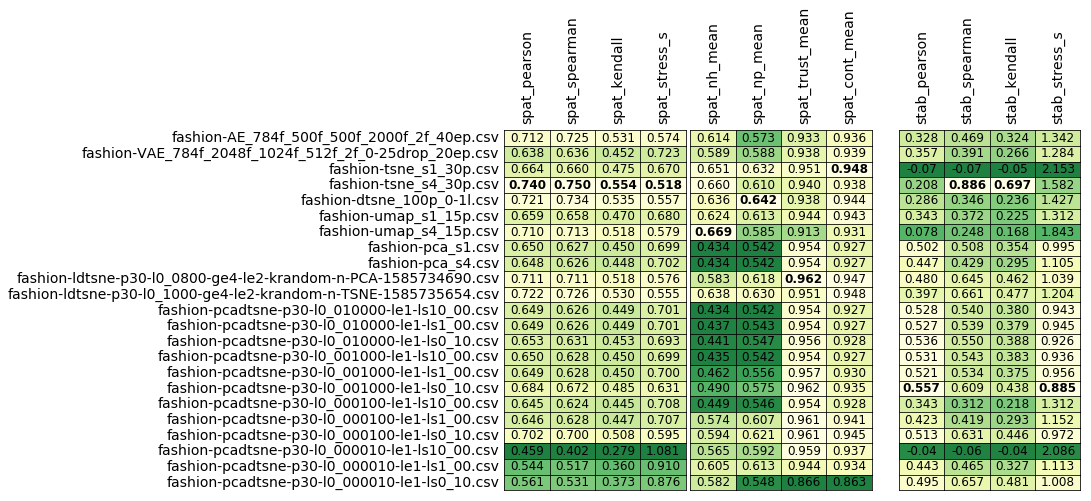

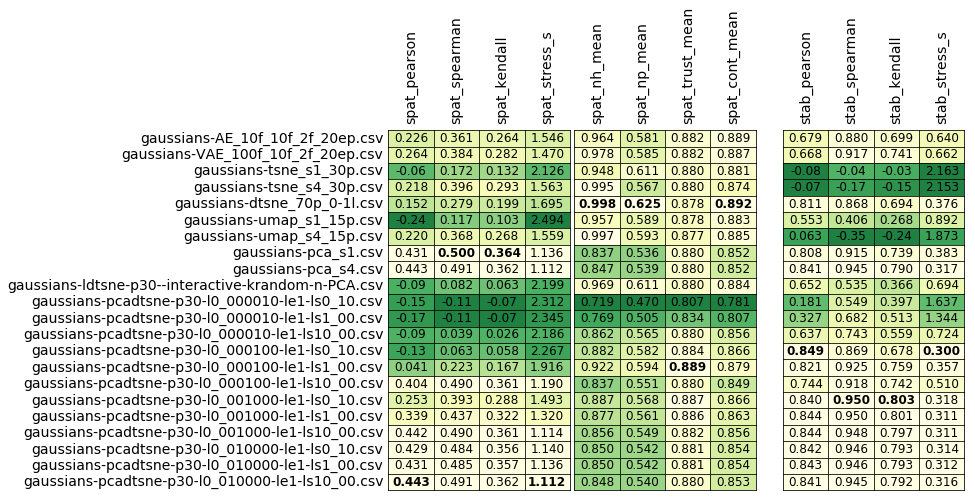

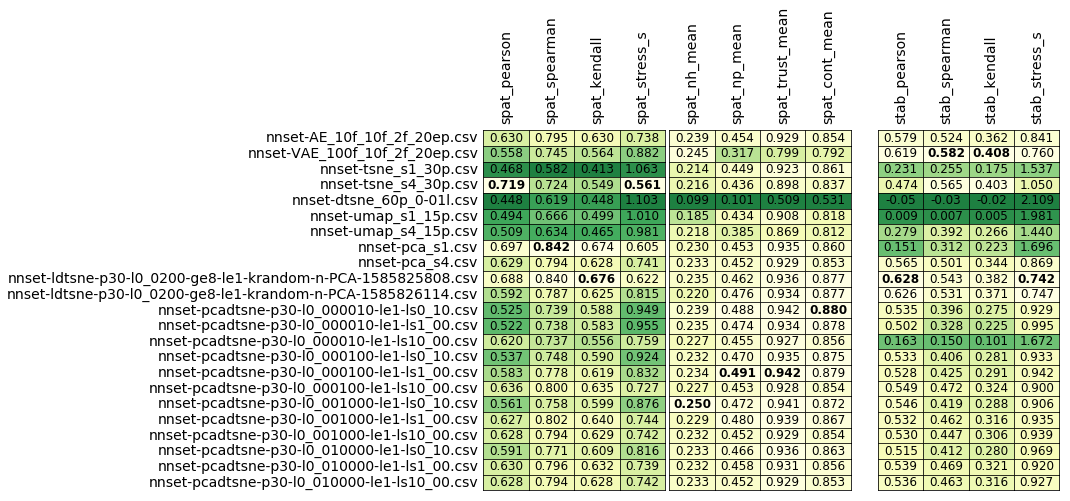

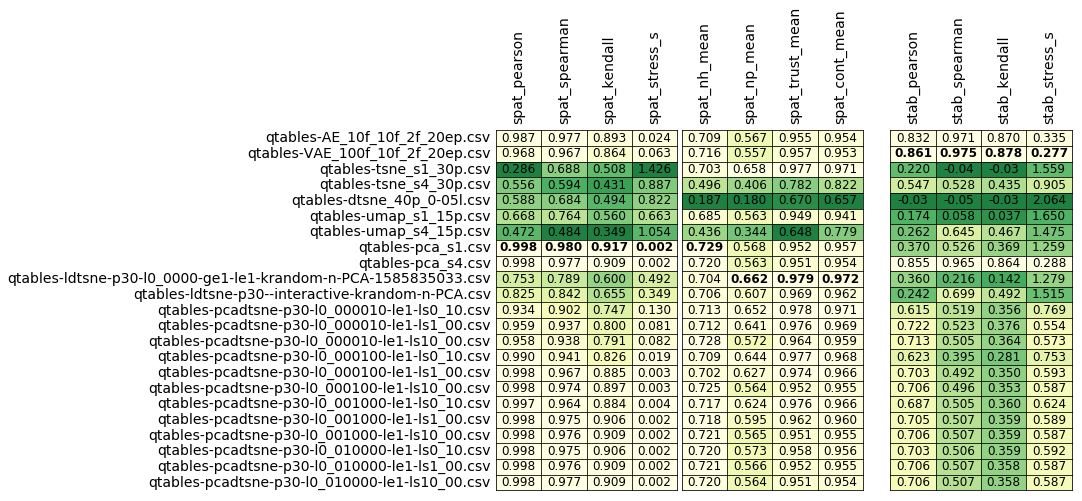

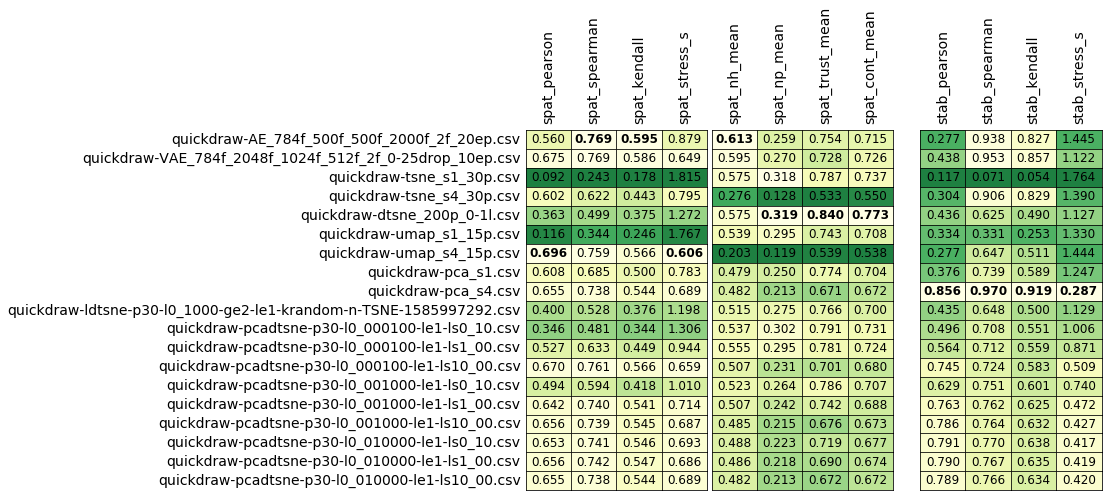

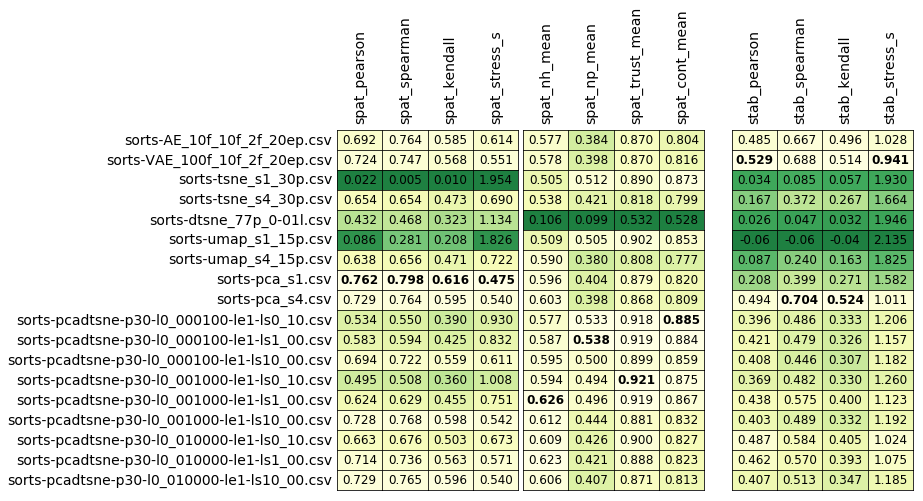

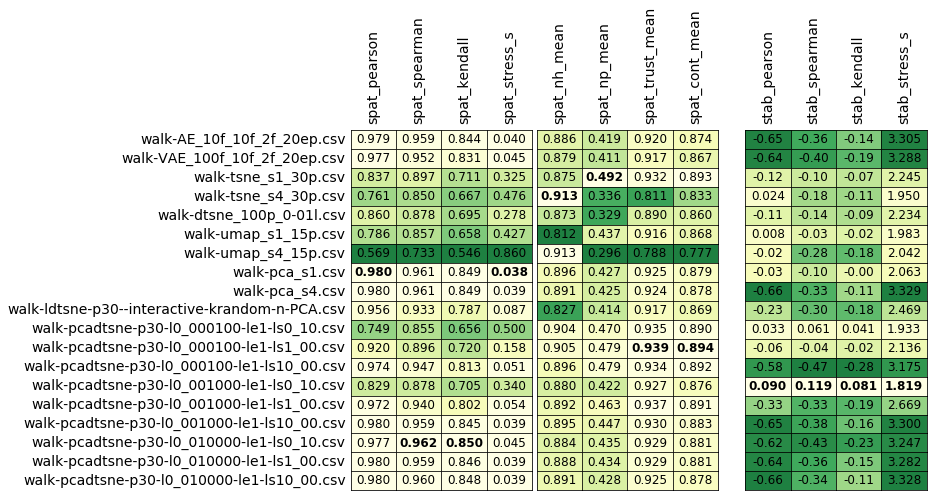

In [8]:
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection

def make_cell(df, index, metric, ax):
    
    avg = df[metric][index]

    colormap_max = max(df[metric])
    colormap_min = min(df[metric])
    metric_max = max(df[metric])
    metric_min = min(df[metric])

    interval = abs(colormap_max - colormap_min)
    if metric in invert_colormap:
        cmap = plt.cm.get_cmap('YlGn')        
        norm = matplotlib.colors.Normalize(vmin=colormap_min, 
                                           vmax=colormap_max + 0.3 * interval)        
    else:
        cmap = plt.cm.get_cmap('YlGn_r')
        norm = matplotlib.colors.Normalize(vmin=colormap_min - 0.3 * interval, 
                                           vmax=colormap_max)

    cell_color = cmap(norm(avg))
    ax.set_facecolor(cell_color)
    
    text = str(avg)[:5]
    if (avg == max(df[metric]) and metric not in invert_colormap) or (avg == min(df[metric]) and metric in invert_colormap):
        ax.text(0.5, 0.5, text, ha='center', va='center', fontsize=12, transform=ax.transAxes, fontweight='bold') # Need to be sure of the center
    else:
        ax.text(0.5, 0.5, text, ha='center', va='center', fontsize=12, transform=ax.transAxes) # Need to be sure of the center
    plt.subplots_adjust(left=0.1, right=0.9, top=1.0, bottom=0.0)    
    ax.set_yticks([])
    ax.set_xticks([])
    

for dataset in df_metrics['dataset'].factorize()[1]:
    df = df_metrics[df_metrics['dataset'] == dataset]
    heights = [1] * len(df)
    widths = [1.0] * 4 + [0.1] + [1.0] * 4 + [0.6] + [1.0] * 4
#     heights = [1.0] * 2 + [0.1] + [1.0] * 3 + [0.1] + [1.0] * 2 + [0.1] + [1.0] * 2 + [0.1] + [1.0] * 1
    fig, axs = plt.subplots( len(df), 14, sharex='col', sharey='row', figsize=(10,5),
                            gridspec_kw={'hspace': 0, 'wspace': 0, 
                                         'width_ratios':widths, 'height_ratios':heights})

    for col_index, metric in enumerate(metrics):        
        if metric.startswith('v_spacer'):
            for row_index in range(len(df)):
                ax = axs[row_index, col_index]
                ax.set_visible(False)
        else: 
            for row_index, index in enumerate(df.index):                
                ax = axs[row_index, col_index]

                if col_index == 0:
                    ax.set_ylabel(index[7:], rotation=0, ha='right', va='center', labelpad=5, fontsize=14)
                if row_index == 0:
                    ax.set_title(metric, rotation=90, ha='center', va='bottom', fontsize=14)

                make_cell(df, index, metric, ax)
